##### Installation of Dependencies

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Data Importing

In [14]:
df = pd.read_csv('journal_bearing.csv')
header = ['speed', 'eccentricity', 'load', 'axial_pos', 'angular_pos', 'thickness', 'pressure']
df.columns = header
zero_pressure_condition = (df['angular_pos']<-2.7) | (df['angular_pos']>1.37)
df = df[~zero_pressure_condition]
# Choose values of eccentricity between 0.3, 0.7
df = df[df['eccentricity'].between(0.3, 0.7)]
df = df.drop(columns=['eccentricity', 'thickness'])

# 2) Train/Test split

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

"""sub_df = df[df['speed'].isin([209.43951023931956, 418.8790204786391])]
sub_df"""

X = df.drop(columns='pressure')
y = df['pressure']

val_condition  = df['speed'].isin([314.1592653589793, 837.7580409572781])
X_train = X[~val_condition]
y_train = y[~val_condition]
X_val = X[val_condition]
y_val = y[val_condition]


scaler = StandardScaler()
scaler.fit(X)
X_train_normalized = scaler.transform(X_train)
X_val_normalized = scaler.transform(X_val)
#X_test_normalized = scaler.transform(X_test)

y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
#y_test = y_test.values.reshape(-1, 1)

# Y is scaled as well in order not to face bias in the multi-task learning towards y values
scaler_target = StandardScaler()
scaler_target.fit(y.values.reshape(-1, 1))
y_train_normalized = scaler_target.transform(y_train)
y_val_normalized = scaler_target.transform(y_val)

#y_test_normalized = scaler_target.transform(y_test)

## 3) Define the Regression Autoencoder

In [4]:
!pip install pydot
!pip install graphviz

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Dense
from keras.losses import mean_squared_error
from keras.optimizers import Adam

# encoding_dim = 2 as we want to visualize it 
def regression_autoencoder(input_dim, encoding_dim=2):
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Encoding layers
    # Input expands then converge into a bottleneck layer
    encoded = Dense(256, activation='relu')(input_layer)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    # Bottleneck layer (Embeddings are produced here)
    encoded = Dense(encoding_dim, activation='relu', name='encoder_output')(encoded)
    
    # Decoding layers
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(input_dim, name='decoded_output')(decoded)
    
    # Regression layer is bounded to the encoded output not the decoded
    regression_output = Dense(1, name='regression_layer')(encoded)
    
    autoencoder = Model(inputs=input_layer, outputs=[decoded, regression_output])
    encoder = Model(inputs=input_layer, outputs=encoded)
    
    autoencoder.compile(optimizer='adam', loss=['mean_squared_error', 'mean_squared_error'])
    
    return autoencoder, encoder


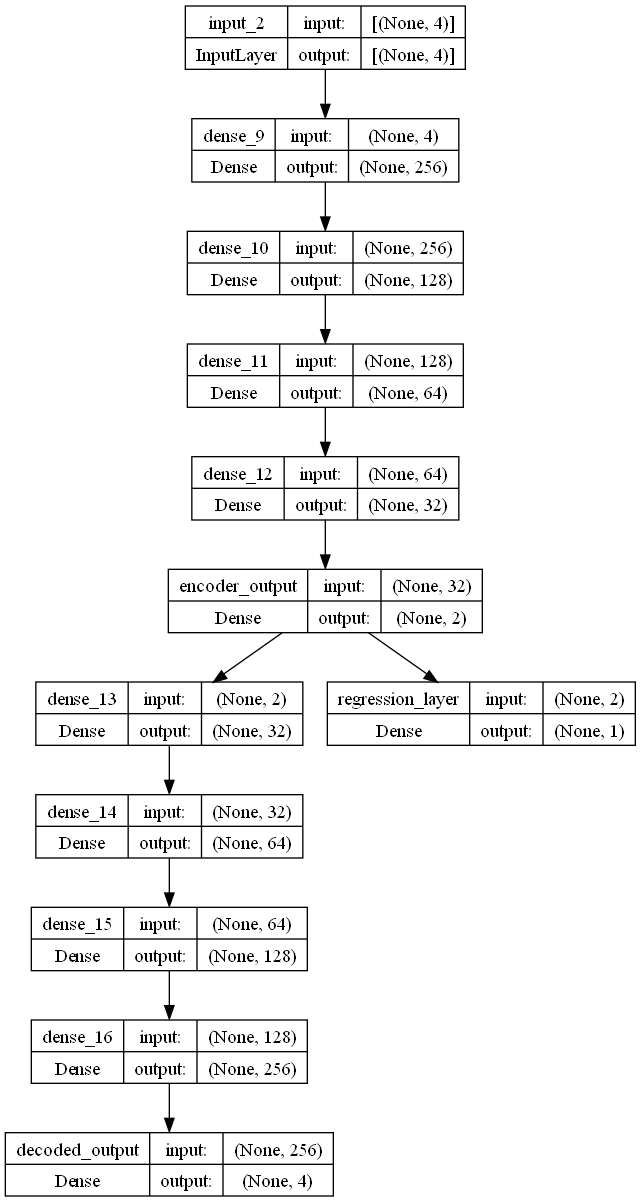

In [5]:
from keras.utils import plot_model

autoencoder, encoder = regression_autoencoder(input_dim=4)
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)


## 4) Train the Regression Autoencoder

In [15]:
import os
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint

# Initialize the autoencoder
input_dim = X_train.shape[1]
autoencoder, encoder = regression_autoencoder(input_dim)

# Ensure the directory to save models exists
save_dir = f'models_reg_autoencoder'
os.makedirs(save_dir, exist_ok=True)

filename = f"model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}__epoch_{{epoch:02d}}__val_loss_{{val_loss:.4f}}.h5"

# ModelCheckpoint callback to save the model after every epoch
checkpoint = ModelCheckpoint(os.path.join(save_dir, "model_epoch_{epoch:02d}.h5"), 
                             monitor='val_loss', 
                             save_best_only=False, 
                             verbose=1) 
# Train the model
history = autoencoder.fit(X_train_normalized, [X_train_normalized, y_train_normalized], epochs=10, batch_size=256, shuffle=True, validation_data=(X_val_normalized, [X_val_normalized, y_val_normalized]), callbacks=[checkpoint])


Epoch 1/10
72833/72844 [============================>.] - ETA: 0s - loss: 0.1934 - decoded_output_loss: 0.1556 - regression_layer_loss: 0.0378
Epoch 1: saving model to models_reg_autoencoder\model_epoch_01.h5
72844/72844 [==============================] - 267s 4ms/step - loss: 0.1934 - decoded_output_loss: 0.1556 - regression_layer_loss: 0.0378 - val_loss: 0.1576 - val_decoded_output_loss: 0.1048 - val_regression_layer_loss: 0.0528
Epoch 2/10
72838/72844 [============================>.] - ETA: 0s - loss: 0.1271 - decoded_output_loss: 0.0991 - regression_layer_loss: 0.0280
Epoch 2: saving model to models_reg_autoencoder\model_epoch_02.h5
72844/72844 [==============================] - 261s 4ms/step - loss: 0.1271 - decoded_output_loss: 0.0991 - regression_layer_loss: 0.0280 - val_loss: 0.1295 - val_decoded_output_loss: 0.0995 - val_regression_layer_loss: 0.0300
Epoch 3/10
72832/72844 [============================>.] - ETA: 0s - loss: 0.1155 - decoded_output_loss: 0.0922 - regression_laye

# 5) Load autoencoder, predict, draw hexbin plot

582750/582750 [==============================] - 454s 778us/step


NameError: name 'special_point_x' is not defined

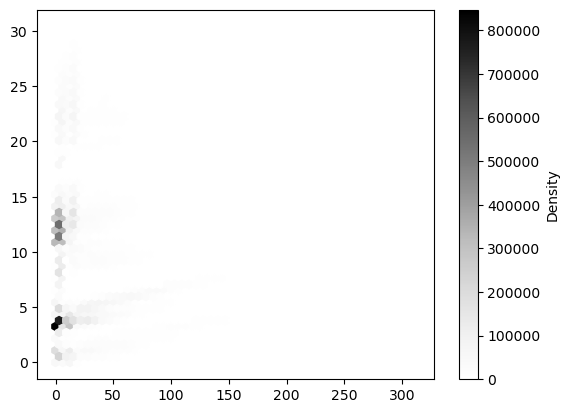

In [17]:
from tensorflow.keras.models import load_model
from keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# This model is chosen based on the performance of training and validation
model_path = 'models_reg_autoencoder/model_epoch_09.h5'

# Load the best model
loaded_autoencoder = load_model(model_path)

def get_encoder_from_autoencoder(autoencoder, encoder_output_name):
    encoder_output = autoencoder.get_layer(encoder_output_name).output
    encoder = Model(inputs=autoencoder.input, outputs=encoder_output)
    return encoder

def get_decoder_output_from_autoencoder(autoencoder, layer_name='decoded_output'):
    layer_output = autoencoder.get_layer(layer_name).output
    return layer_output


# Extract input layer
input_layer = loaded_autoencoder.input

# Extract encoder
loaded_encoder = get_encoder_from_autoencoder(loaded_autoencoder, encoder_output_name='encoder_output')

# Extract decoder
decoder_output = get_decoder_output_from_autoencoder(loaded_autoencoder)


# Reduce dimensions (Produce embeddings)
encoded_data = loaded_encoder.predict(X_train_normalized)
# Hexbin plot showing density of points in a hexbin
plt.hexbin(encoded_data[:,0], encoded_data[:,1], gridsize=50, cmap='Greys')
plt.colorbar(label='Density')
#plt.savefig('Images/hexbin.png', dpi=300, bbox_inches='tight')  
plt.show()

### The upcoming cell takes some time. Optimal number of clusters is 3 based on the elbow graph.

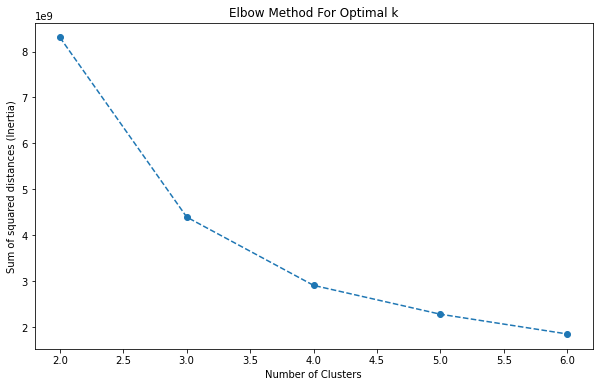

In [21]:

# Calculate the sum of squared distances for a range of cluster counts
inertia = []
range_clusters = range(2,7)  # assuming you want to check for up to 10 clusters

for num_clusters in range_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(encoded_data)
    inertia.append(kmeans.inertia_)

# Plot the sum of squared distances to observe 'the elbow'
plt.figure(figsize=(10,6))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances (Inertia)')
plt.show()

## 6) Apply K-means clustering on embeddings

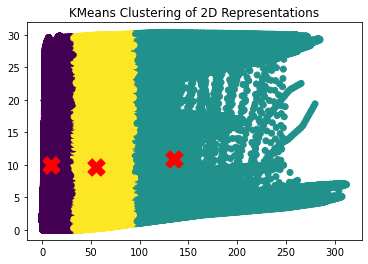

In [17]:
# KMeans clustering
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(encoded_data)

plt.scatter(encoded_data[:,0], encoded_data[:,1], c=clusters, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
#plt.title("KMeans Clustering of 2D Representations")
plt.show()

## Apply stratified sampling and visualize again

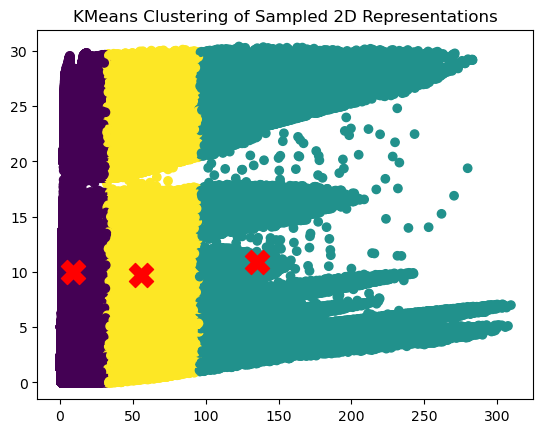

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

# Stratified sampling
splits = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)

for train_index, sample_index in splits.split(encoded_data, clusters):
    sample_data = encoded_data[sample_index]
    sample_clusters = clusters[sample_index]

# Visualization
plt.scatter(sample_data[:,0], sample_data[:,1], c=sample_clusters, cmap='viridis')

# Displaying the original KMeans cluster centers. If you wanted to refit KMeans on the sample_data, you'd adjust this.
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')

plt.title("KMeans Clustering of Sampled 2D Representations")
#plt.savefig('Images/stratified_sampling.png', dpi=300, bbox_inches='tight')
plt.show()


## 7) Contour plot to see the embeddings' target values
### We conclude from this contour plot along with the clustering k-means graph that points are clustered close to each other if they have similar feature and target values (target values of each cluster are roughly the same as per the contour plot)

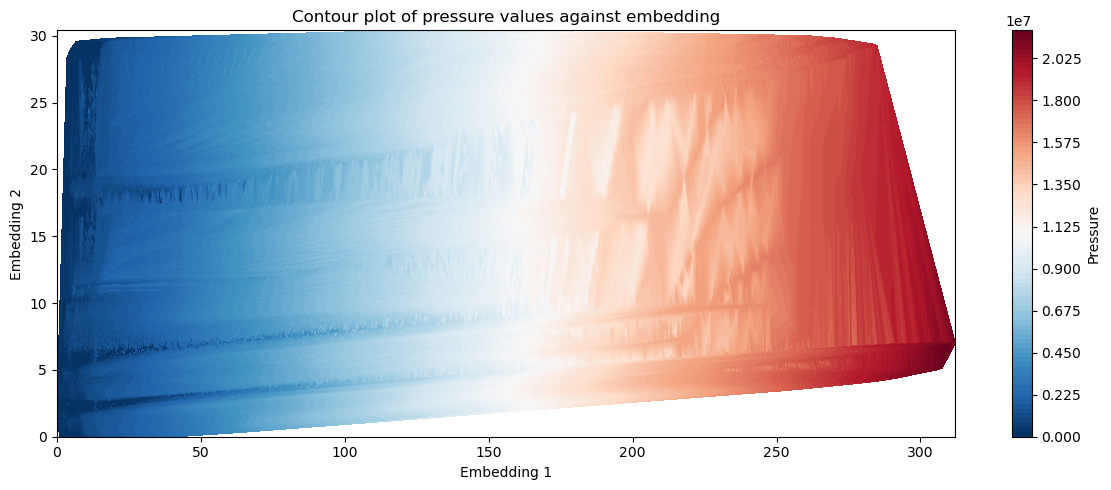

In [12]:
# Sample data
x = encoded_data[:, 0]
y = encoded_data[:, 1]
z = y_train.flatten()


plt.figure(figsize=(12, 5))

# Create a filled contour plot using tricontourf
contour = plt.tricontourf(x, y, z, cmap='RdBu_r', levels=100)

# Add a colorbar
plt.colorbar(contour, label="Pressure")

plt.title('Contour plot of pressure values against embedding')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')

plt.tight_layout()
#plt.savefig("Images/embedding_contour.png", dpi=300, bbox_inches='tight')
plt.show()

## 8) Prepare the Instance selection autoencoder class for later use

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit


# Reduce dataset using stratified sampling on embeddings


class IS_regression_autoencoder:
    def __init__(self, path):
        self.path = path
        
    def get_encoder_from_autoencoder(self, autoencoder, encoder_output_name):
        encoder_output = autoencoder.get_layer(encoder_output_name).output
        encoder = Model(inputs=autoencoder.input, outputs=encoder_output)
        return encoder

    def load_autoencoder(self):
        loaded_autoencoder = load_model(self.path)
        # Extract encoder architecture from the loaded autoencoder
        input_layer = loaded_autoencoder.input

        # Use the function to extract the encoder
        self.loaded_encoder = self.get_encoder_from_autoencoder(loaded_autoencoder, encoder_output_name='encoder_output')
        
    def produce_embedding(self, X_train_normalized):
        # Reduce dimensions
        encoded_data = self.loaded_encoder.predict(X_train_normalized)
        return encoded_data

    def draw_embeddings(self):
        # Hexbin plot
        plt.hexbin(encoded_data[:,0], encoded_data[:,1], gridsize=50, cmap='Greys')
        plt.colorbar()
        plt.title("Hexbin Plot of 2D Representations")
        plt.show()
    
    def reduce_data_stratified_sampling(self, encoded_data, y_values):
        # First fit the data using KMeans clustering 
        kmeans = KMeans(n_clusters=3)
        clusters = kmeans.fit_predict(encoded_data)

        # Stratified sampling
        splits = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)

        for train_index, sample_index in splits.split(encoded_data, clusters):
            sampled_data = encoded_data[sample_index]
            sampled_y_values = y_values[sample_index]
            sampled_clusters = clusters[sample_index]
        return sampled_data, sampled_y_values


model_path = 'models_reg_autoencoder/model_20230818_000910__epoch_02__val_loss_0.3449.h5'
reg_autoencoder = IS_regression_autoencoder(model_path)  
reg_autoencoder.load_autoencoder()
encoded_data = reg_autoencoder.produce_embedding(X_train_normalized)
reduced_data = reg_autoencoder.reduce_data_stratified_sampling(encoded_data, y_train)

"""# Visualization
plt.scatter(sample_data[:,0], sample_data[:,1], c=sample_clusters, cmap='viridis')

# Displaying the original KMeans cluster centers. If you wanted to refit KMeans on the sample_data, you'd adjust this.
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')

plt.title("KMeans Clustering of Sampled 2D Representations")
plt.show()"""